In [1]:
import sys
import os
sys.path.insert(1, '/cmlscratch/xic/FairRL/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# for smoothing
from scipy.ndimage.filters import gaussian_filter1d

/tmp/ipykernel_3824909/2378886784.py:9: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [17]:

def plot_return_bias(exp_path, save=True, smooth=-1):
    
    # read data
    data_pth  = os.path.join(exp_path,'eval.csv') 
    data_pth  = os.path.join(exp_path,'eval.csv') 
    data = pd.read_csv(data_pth, sep=',', header=0)
    
    # to numpy
    num_samples = data['num_timesteps'].to_numpy()

    return_arr = data['return'].to_numpy() # this is the reward averaged across timesteps and episodes, as in attention_allocation_experiment.agents.ppo.sb3.utils_fair
    benefit_max = data['benefit_max'].to_numpy()
    benefit_min = data['benefit_min'].to_numpy()
    bias = data['bias'].to_numpy()
    
    if smooth > 0:
        return_arr = gaussian_filter1d(return_arr, sigma=smooth)
        benefit_max = gaussian_filter1d(benefit_max, sigma=smooth)
        benefit_min = gaussian_filter1d(benefit_min, sigma=smooth)
        bias = gaussian_filter1d(bias, sigma=smooth)
    
    # plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (8,8), sharex=True)
    # fig, (ax1, ax3) = plt.subplots(2, figsize = (8,8), sharex=True)
    fig.suptitle('exp path: {}'.format(exp_path))
    # return
    ax1.plot(num_samples,return_arr)
    ax1.set_ylabel('return')
    ax1.set_title('average return / episode_len')
    ax1.set_ylim(-10,-2.5)
    ax1.grid()
    # benefit
    ax2.plot(num_samples,benefit_max,label='benefit_max')
    ax2.plot(num_samples,benefit_min,label='benefit_min')
    ax2.legend()
    ax2.set_ylabel('benefit')
    ax2.set_title('benefit max and min')
    # bias
    ax3.plot(num_samples,bias)
    ax3.set_xlabel('Samples')
    ax3.set_ylabel('Bias')
    ax3.axhline(y=0, color='r', linestyle='-')
    ax3.set_title('Bias')
    ax3.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax3.set_ylim(0,0.35)
    ax3.grid()
    if save:
        fig.savefig(os.path.join(EXP_DIR,exp_path,'result.png'))
    else:
        fig.show()

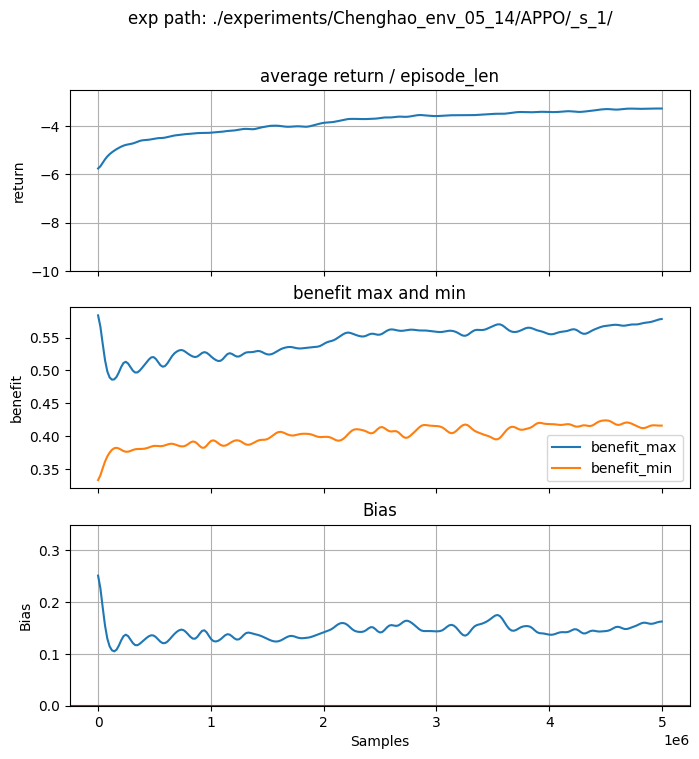

In [22]:
exp_path_base = './experiments/Chenghao_env_05_14/APPO/_s_1/'
plot_return_bias(exp_path_base,save=False, smooth = 2)

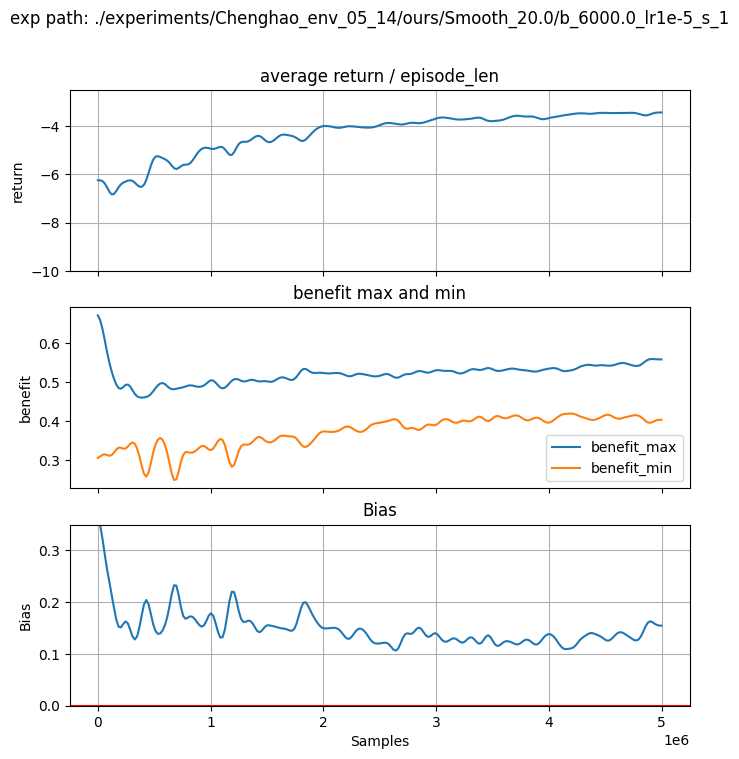

In [27]:
exp_path_base = './experiments/Chenghao_env_05_14/ours/Smooth_20.0/'
beta_list = [6000]

for beta in beta_list:
    plot_return_bias(os.path.join(exp_path_base, 'b_'+ str(beta)+ '.0_lr1e-5' + str('_s_1')),save=False, smooth = 2)

In [7]:
# exp_path_base = './experiments/Chenghao_env_05_14/ours/Smooth_5.0/'
# beta_list = [0,4000,6000,8000]
# beta_list = [0,2000,4000,6000]
# beta_list = [0,200,500,1000,2000,4000,6000,8000]

# # exp_path_base = './experiments/original/ours/Smooth_5.0/'
# # beta_list = [0,10,20,50]

# # exp_path_base = './experiments/original/ours/Smooth_10.0/'
# # beta_list = [0,20,50,100]

# for beta in beta_list:
#     # plot_return_bias(os.path.join(exp_path_base, 'b_'+ str(beta)+ '.0' + str('_s_1')),save=False, smooth = 2)
#     plot_return_bias(os.path.join(exp_path_base, 'b_'+ str(beta)+ '.0_lr1e-4' + str('_s_0')),save=False, smooth = 2)